# A Guide to Time Series Forecasting with Prophet in Python 3

这个Notebook主要介绍了如何利用 Prophet 基于现有的时间序列数据进行预测。
注意：FBProphet不支持pystan3.0以上，要安装pystan 2.19.1.1：

!conda install pystan

!pip install prophet

## Prophet in Python

ARIMA 模块需要非常复杂的手动过程来获取模型的参数， R 语言提供了一套参数自动优化的方法。Prophet 是 由 Facebook 的 Core Data Science 团队开源的一套针对时间序列基于 Python 和 R 语言的数据预测工具，其工作发表在论文《Forecasting at scale》(Taylor S J, LethamB. Forecasting at scale[J]. The American Statistician, 2018, 72(1): 37-45)。
    - 注：“at scale”是指数据的复杂度（如数据中存在大量异常点）和预测结果的评估复杂度，不是常说的数据存储和计算复杂度。
用于预测的时间任务常具有以下特征：
    - 对于历史在至少几个月（最好是一年）的每小时、每天或每周的观察
    - 强大的多次的「人类规模级」的季节性：每周的一些天和每年的一些时候
    - 事先知道的以不定期的间隔发生的重要节假日（如，双十一）
    - 合理数量的缺失的观察或大量异常
    - 历史趋势改变，比如因为产品发布或记录变化
    - 非线性增长曲线的趋势，其中有的趋势达到了自然极限或饱和

## 系统要求

1. Language: Python 3
2. Library:  pandas, matplotlib, numpy, cython, fbprophet
3. Others(Optional): Annaconda, Jupyter notebook

## Step 1 Loading Time-series Data

### 1）载入系统所需库
- 注：可能会出现错误 ERROR:fbprophet:Importing plotly failed. Interactive plots will not work. 可能是没有安装 plotly 模块的原因
    > 可行的解决方法： pip install --upgrade plotly

In [2]:
%matplotlib inline
import pandas as pd
from prophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### 2）工作的数据集

- 名称：Box and Jenkins (1976) Airline Passengers dataset
- 内容：收集了从 1949 年到 1960 年期间每月飞机乘客数量。
> curl -O https://assets.digitalocean.com/articles/eng_python/prophet/AirPassengers.csv

In [4]:
df = pd.read_csv('./data/AirPassengers.csv')

df.head(5)

,Month,AirPassengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


- 查看 df 的格式并转换为**datetime**类型

In [5]:
df.dtypes

Month            object
AirPassengers     int64
dtype: object

In [6]:
df['Month'] = pd.DatetimeIndex(df['Month'])
df.dtypes

Month            datetime64[ns]
AirPassengers             int64
dtype: object

In [7]:
df = df.rename(columns={'Month': 'ds',
                        'AirPassengers': 'y'})
df.head(5)

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


- 画图*

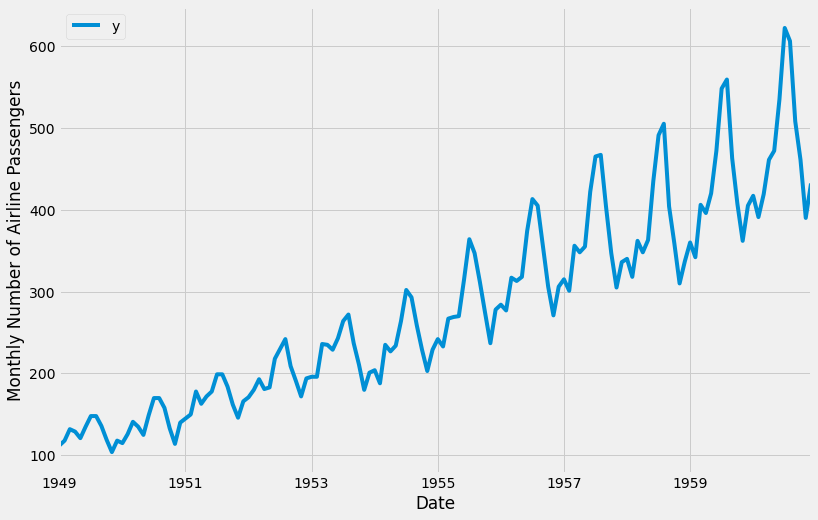

In [8]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')

plt.show()

## Step 2 Time Series Forecasting with Prophet

- 创建 Prophet 对象并完成初始化

In [9]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(weekly_seasonality=True, daily_seasonality=True, interval_width=0.95)

In [10]:
my_model.fit(df)

Initial log joint probability = -2.46502


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86        402.49   0.000676221       103.922   7.337e-06       0.001      140  LS failed, Hessian reset 
      99       402.571   8.49493e-05       49.1693           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       402.904    0.00119481       73.3776           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       402.919    0.00031859       75.4692   5.602e-06       0.001      327  LS failed, Hessian reset 
     275       402.958   6.82597e-09       69.9163      0.2386      0.2386      427   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


- 添加数据列记录预测数据

In [11]:
future_dates = my_model.make_future_dataframe(periods=36, freq='MS')
future_dates.tail()

,ds
175,1963-08-01
176,1963-09-01
177,1963-10-01
178,1963-11-01
179,1963-12-01


- 采用 predict 方法来预测数据并填充

In [12]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
175,1963-08-01,650.609667,607.119800,692.788798
176,1963-09-01,601.265473,559.338570,646.842896
177,1963-10-01,562.342559,518.476168,607.573465
178,1963-11-01,540.188710,497.054983,583.757633
179,1963-12-01,562.817466,522.771754,606.379961


- 画图
    - 黑点：观察值
    - 蓝线：预测值
    - 灰蓝色区域：不确定区间

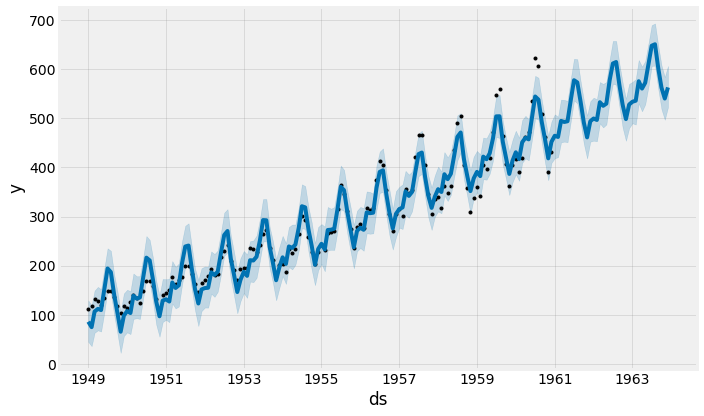

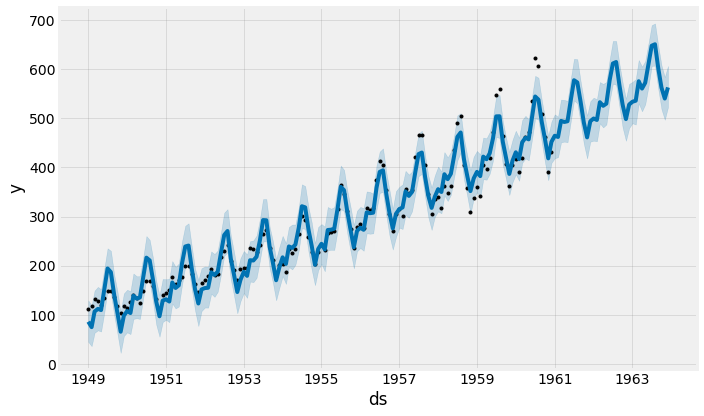

In [13]:
my_model.plot(forecast,
              uncertainty=True)

振幅不是常数，尝试乘法模型

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.164    0.00404329       133.096      0.7795      0.7795      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       503.029    0.00011625       61.0812      0.7463      0.7463      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       503.241   0.000197464       74.1894      0.6815      0.6815      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       503.429   0.000269211       170.518   3.444e-06       0.001      512  LS failed, Hessian reset 
     399       503.521    0.00012352       74.8921      0.4361      0.4361      542   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     428       503.524   4.87946e-06    

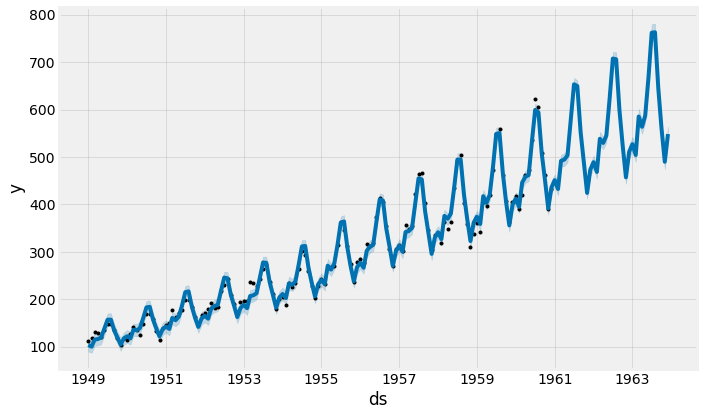

In [14]:
m_model = Prophet(seasonality_mode='multiplicative')
m_model.fit(df)
forecast = m_model.predict(future_dates)
fig = m_model.plot(forecast)